In [1]:
!pip install tensorflow numpy h5py scikit-learn matplotlib

In [2]:
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [3]:
# --- Step 1: Data Loading and Preprocessing ---
def load_h5_data(directory, is_training=True, target_size=(256, 256), max_samples=None):
    images, masks = [], []
    sample_count = 0
    
    for filename in os.listdir(directory):
        if max_samples and sample_count >= max_samples:
            break
        if filename.endswith('.h5'):
            try:
                with h5py.File(os.path.join(directory, filename), 'r') as f:
                    image = f['image'][:]  # Shape: (H, W) or (slices, H, W)
                    if is_training:
                        mask = f['label'][:]  # Shape: (H, W) or (slices, H, W)
                    
                    # Handle 3D volumes (test data) or 2D slices (training data)
                    if image.ndim == 3:  # (slices, H, W)
                        for slice_idx in range(image.shape[0]):
                            slice_img = image[slice_idx]  # (H, W)
                            slice_img = np.expand_dims(slice_img, axis=-1)  # (H, W, 1)
                            slice_img = tf.image.resize(slice_img, target_size, method='bilinear').numpy()
                            images.append(slice_img)
                            if is_training:
                                slice_mask = mask[slice_idx]
                                slice_mask = np.expand_dims(slice_mask, axis=-1)
                                slice_mask = tf.image.resize(slice_mask, target_size, method='nearest').numpy()
                                masks.append(np.squeeze(slice_mask, axis=-1))
                    elif image.ndim == 2:  # (H, W)
                        image = np.expand_dims(image, axis=-1)  # (H, W, 1)
                        image = tf.image.resize(image, target_size, method='bilinear').numpy()
                        images.append(image)
                        if is_training:
                            mask = np.expand_dims(mask, axis=-1)
                            mask = tf.image.resize(mask, target_size, method='nearest').numpy()
                            masks.append(np.squeeze(mask, axis=-1))
                    else:
                        print(f"Unexpected shape in {filename}: {image.shape}")
                        continue
                    
                    sample_count += 1
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue
    
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.uint8) if is_training else None
    return images, masks

In [4]:
# Load training data
train_dir = '/kaggle/input/acdc-dataset/ACDC_preprocessed/ACDC_training_slices'
train_images, train_masks = load_h5_data(train_dir, is_training=True, target_size=(256, 256), max_samples=500)

# Normalize images to [0, 1]
train_images = train_images / np.max(train_images)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Load test data
test_dir = '/kaggle/input/acdc-dataset/ACDC_preprocessed/ACDC_testing_volumes'
test_images, _ = load_h5_data(test_dir, is_training=False, target_size=(256, 256), max_samples=50)  # Reduced for memory

# Normalize test images
test_images = test_images / np.max(test_images)

print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {test_images.shape}")

Training shape: (400, 256, 256, 1), Validation shape: (100, 256, 256, 1), Test shape: (515, 256, 256, 1)


In [5]:
# --- Step 2: Define DUCK-Net Model ---
import tensorflow as tf
from tensorflow.keras import layers, models

def duck_net_with_aspp(input_shape, num_classes=4):
    inputs = layers.Input(input_shape)
    
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x
    
    # Downsampling path
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 256)
    
    # ASPP Bottleneck
    def aspp_block(x):
        """ Atrous Spatial Pyramid Pooling (ASPP) """
        shape = x.shape[1:3]  # Extract spatial dimensions

        # Atrous Convolutions at multiple rates
        conv1 = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
        conv3_6 = layers.Conv2D(256, 3, dilation_rate=6, padding="same", activation="relu")(x)
        conv3_12 = layers.Conv2D(256, 3, dilation_rate=12, padding="same", activation="relu")(x)
        conv3_18 = layers.Conv2D(256, 3, dilation_rate=18, padding="same", activation="relu")(x)

        # Global Average Pooling
        avg_pool = layers.GlobalAveragePooling2D()(x)
        avg_pool = layers.Reshape((1, 1, x.shape[-1]))(avg_pool)
        avg_pool = layers.Conv2D(256, 1, padding="same", activation="relu")(avg_pool)
        avg_pool = layers.UpSampling2D(size=shape)(avg_pool)  # Restore spatial dimensions

        # Concatenate ASPP Features
        x = layers.Concatenate()([conv1, conv3_6, conv3_12, conv3_18, avg_pool])
        x = layers.Conv2D(512, 1, padding="same", activation="relu")(x)  # Projection
        return x
    
    bottleneck = aspp_block(c4)
    
    # Upsampling path with skip connections
    u4 = layers.UpSampling2D((2, 2))(bottleneck)
    u4 = layers.Concatenate()([u4, c3])
    c5 = conv_block(u4, 256)
    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Concatenate()([u3, c2])
    c6 = conv_block(u3, 128)
    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.Concatenate()([u2, c1])
    c7 = conv_block(u2, 64)
    
    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c7)
    
    model = models.Model(inputs, outputs)
    return model


In [6]:
# Set input shape
input_shape = (256, 256, 1)
model = duck_net_with_aspp(input_shape, num_classes=4)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64, 64, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 6,447,460 (24.60 MB)

 Trainable params: 6,443,748 (24.58 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [7]:
# --- Step 3: Training the Model ---
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1071s 21s/step - accuracy: 0.6677 - loss: 1.2513 - val_accuracy: 0.0453 - val_loss: 16.1907
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1058s 21s/step - accuracy: 0.9760 - loss: 0.4412 - val_accuracy: 0.4094 - val_loss: 3.0758
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1133s 22s/step - accuracy: 0.9813 - loss: 0.1882 - val_accuracy: 0.9627 - val_loss: 0.1888
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1063s 21s/step - accuracy: 0.9814 - loss: 0.1162 - val_accuracy: 0.9626 - val_loss: 0.2055
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1059s 21s/step - accuracy: 0.9866 - loss: 0.0672 - val_accuracy: 0.9628 - val_loss: 0.2128
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1055s 21s/step - accuracy: 0.9905 - loss: 0.0425 - val_accuracy: 0.9638 - val_loss: 0.1749
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1063s 21s/step - accuracy: 0.9905 - loss: 0.0397 - val_accuracy: 0.9680 - val_loss: 0.1503
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1061s 21s/step - accuracy: 0.9920 - loss: 0.0298 - val_acc

In [8]:
# --- Step 4: Evaluation Metrics ---
def compute_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
    
    dice = 2 * np.sum(y_true_flat * y_pred_flat) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-6)
    jaccard = np.sum(y_true_flat * y_pred_flat) / (np.sum(y_true_flat) + np.sum(y_pred_flat) - np.sum(y_true_flat * y_pred_flat) + 1e-6)
    precision = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    
    return dice, jaccard, precision, recall, accuracy

# Predict on validation and test sets
val_preds = model.predict(X_val)
test_preds = model.predict(test_images)

# Compute metrics on validation set
dice, jaccard, precision, recall, accuracy = compute_metrics(y_val, val_preds)
print(f"Validation Metrics - Dice: {dice:.4f}, Jaccard: {jaccard:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 13s/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 301s 18s/step
Validation Metrics - Dice: 1.7789, Jaccard: 8.0440, Precision: 0.8195, Recall: 0.5153, Accuracy: 0.9756


Validation Set Visualization (Ground Truth vs Predicted):


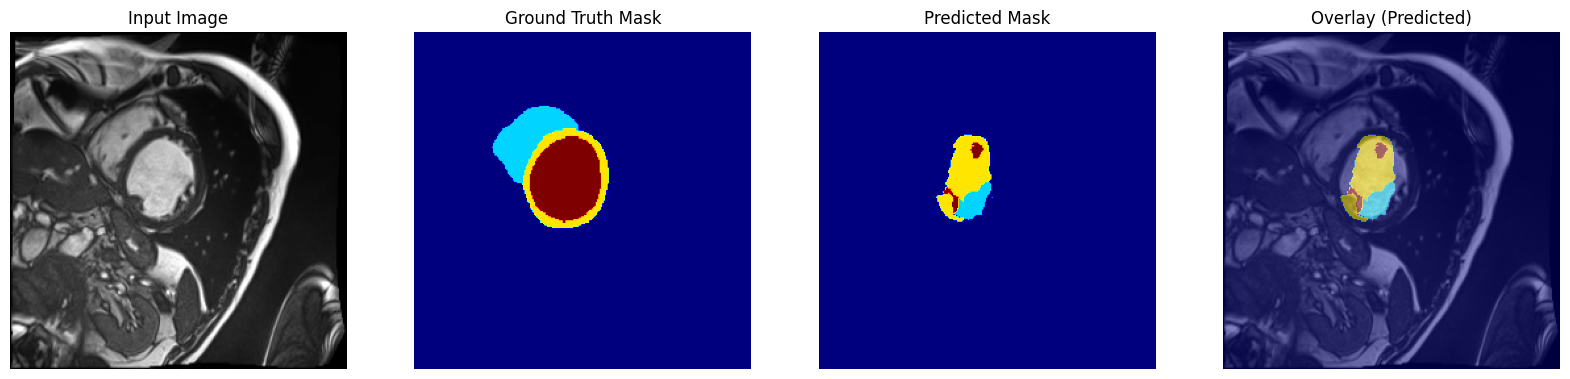

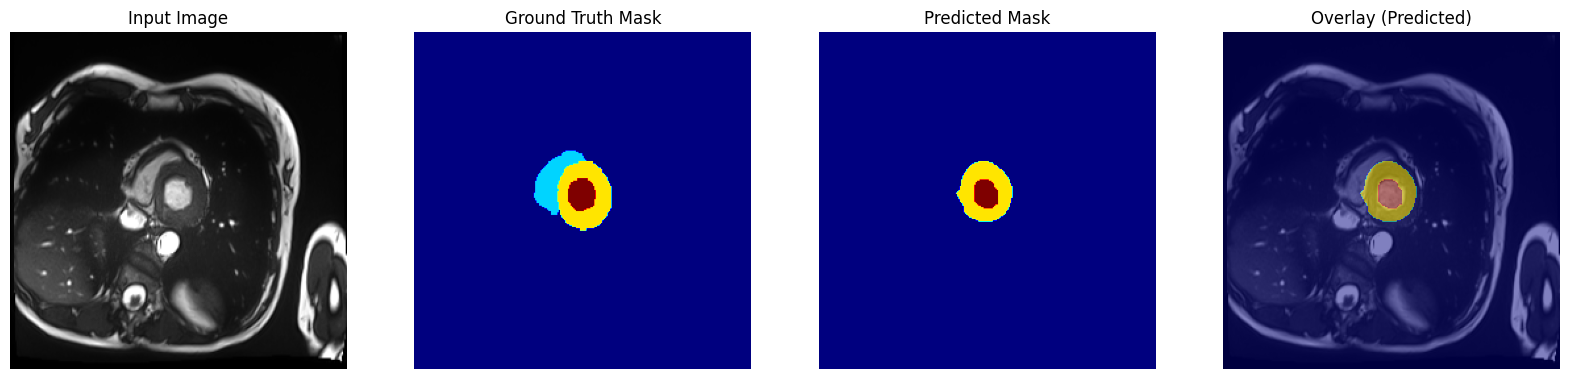

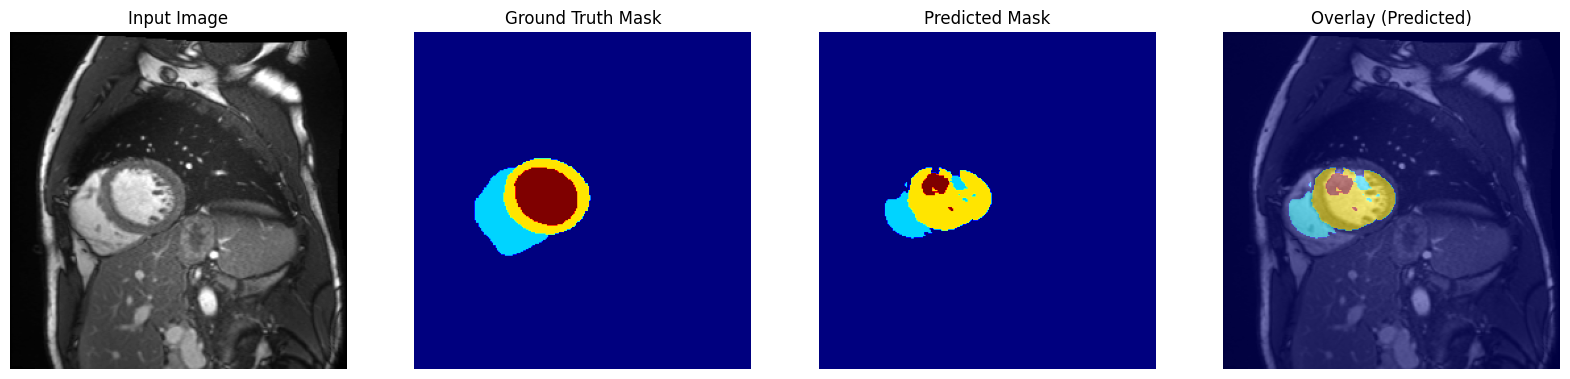

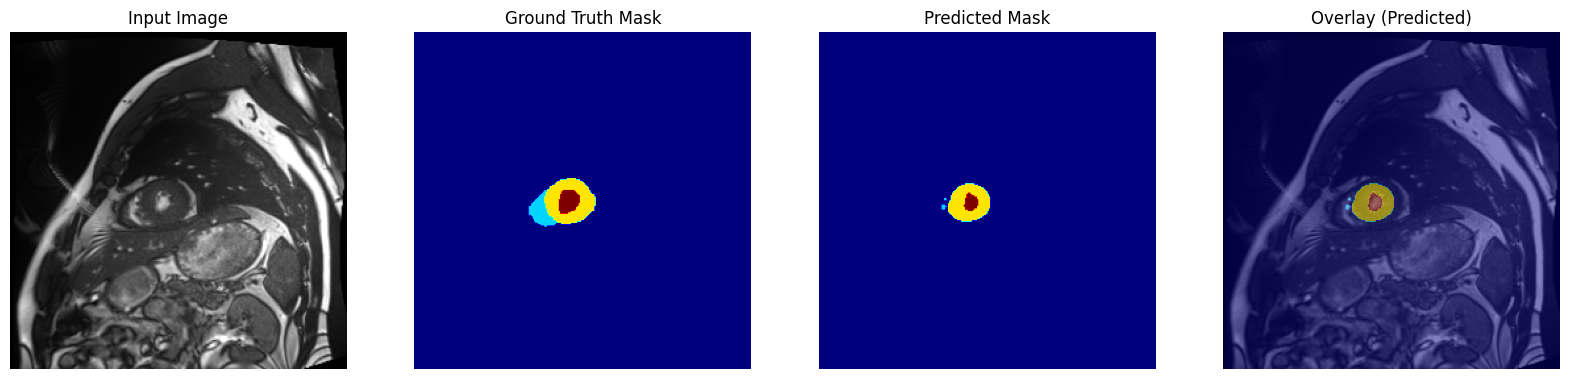

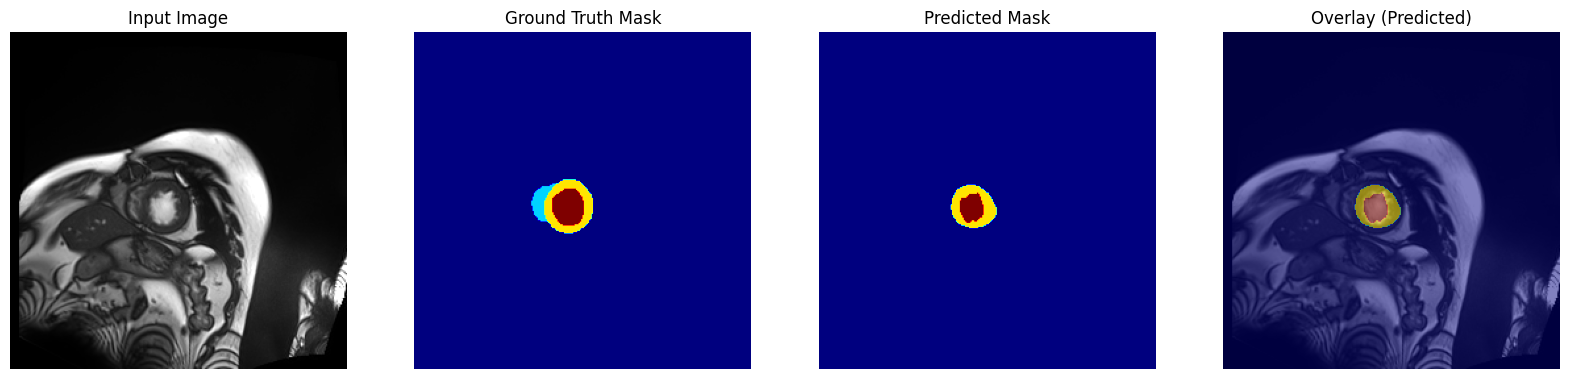

Test Set Visualization (Predicted Only):


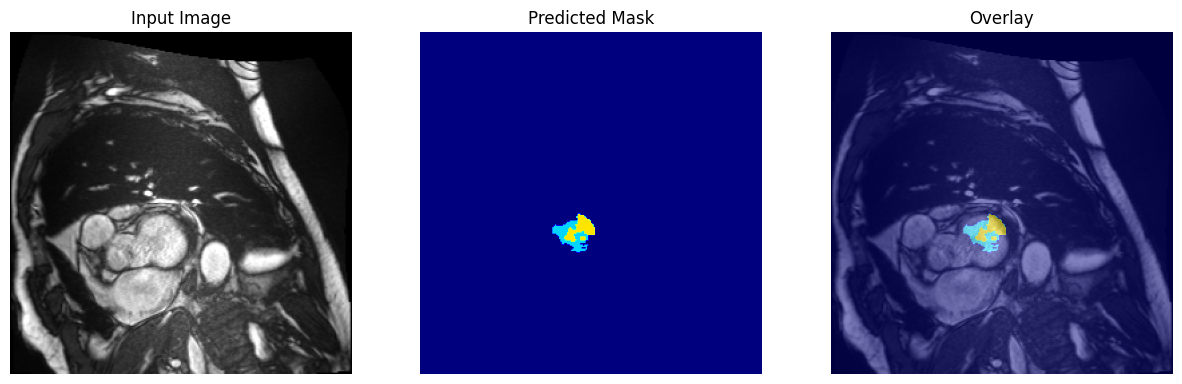

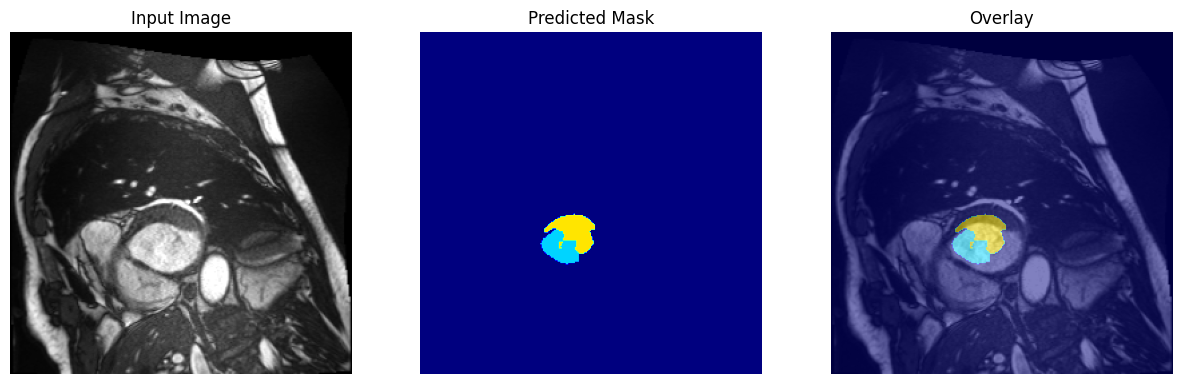

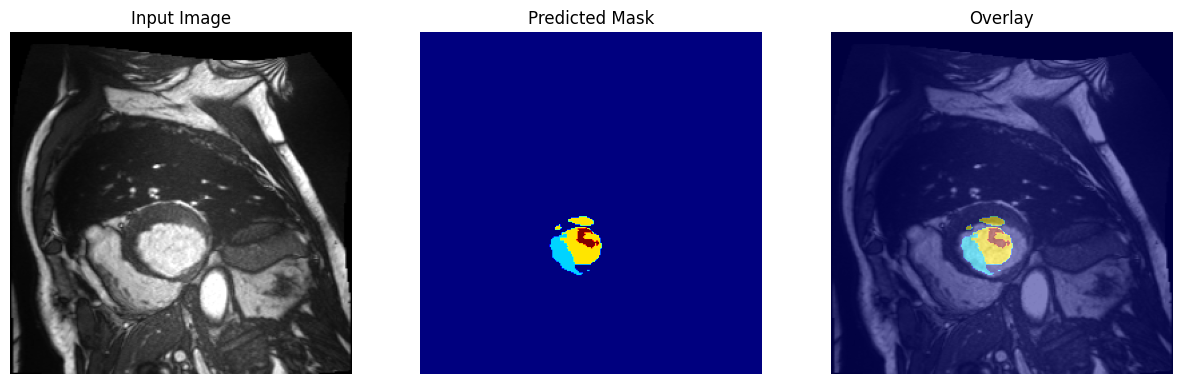

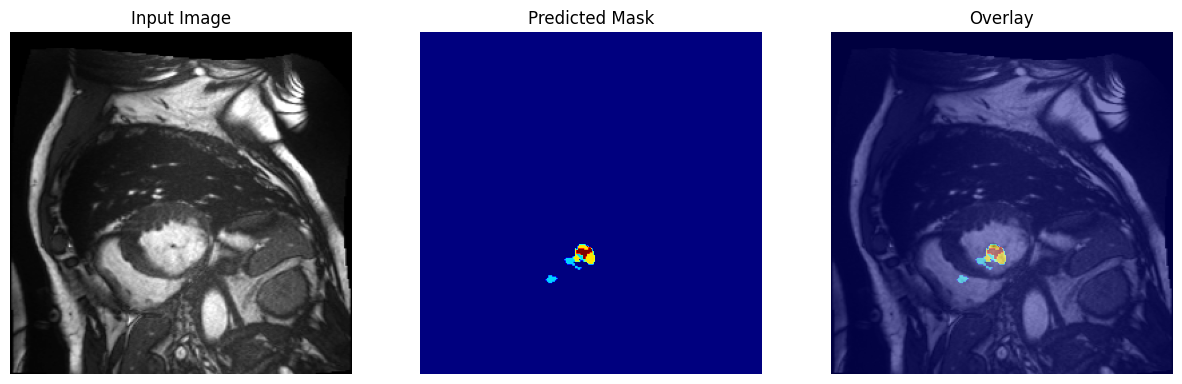

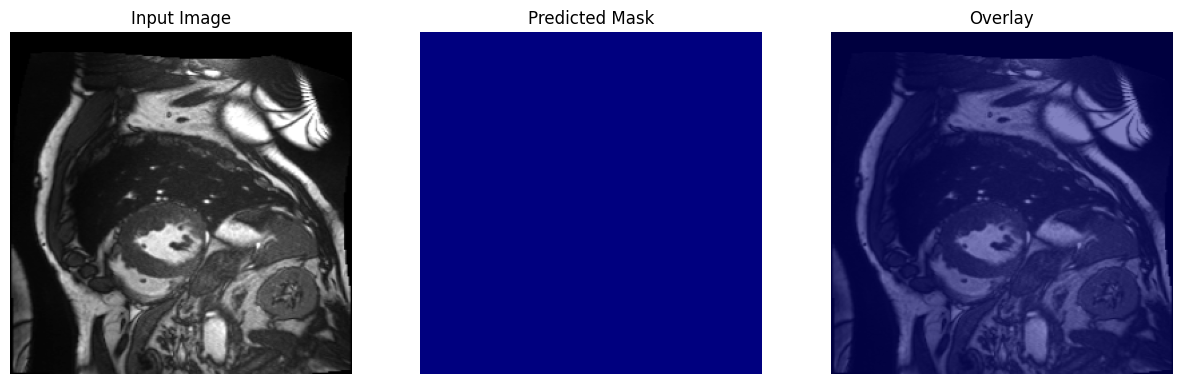

In [9]:
# --- Step 5: Visualization ---
# Validation Set Visualization (with ground truth)
print("Validation Set Visualization (Ground Truth vs Predicted):")
for i in range(5):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title("Input Image")
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y_val[i], cmap='jet', vmin=0, vmax=3)  # 0: background, 1: LV, 2: RV, 3: MYO
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.argmax(val_preds[i], axis=-1), cmap='jet', vmin=0, vmax=3)
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title("Overlay (Predicted)")
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    plt.imshow(np.argmax(val_preds[i], axis=-1), cmap='jet', alpha=0.5, vmin=0, vmax=3)
    plt.axis('off')
    plt.show()

# Test Set Visualization (no ground truth)
print("Test Set Visualization (Predicted Only):")
for i in range(5):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(test_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(np.argmax(test_preds[i], axis=-1), cmap='jet', vmin=0, vmax=3)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(test_images[i, :, :, 0], cmap='gray')
    plt.imshow(np.argmax(test_preds[i], axis=-1), cmap='jet', alpha=0.5, vmin=0, vmax=3)
    plt.axis('off')
    plt.show()

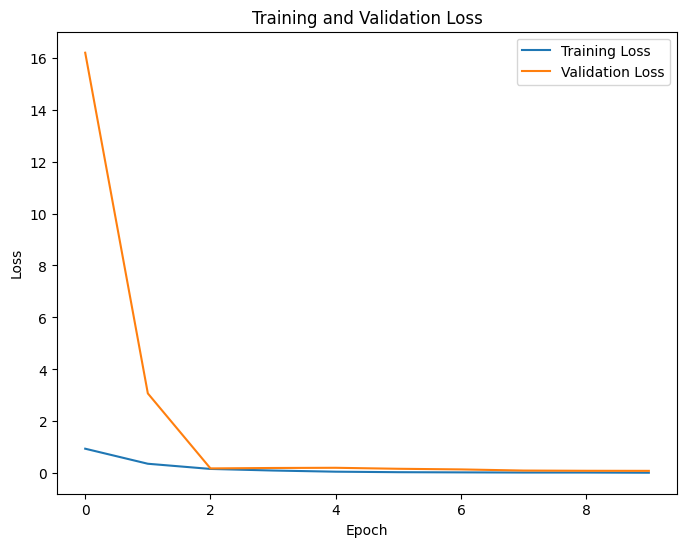

In [10]:
# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()